In [1]:
# Import all necessary packages to run functions
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from FlowCytometryTools import FCMeasurement
from FlowCytometryTools import QuadGate, ThresholdGate
import sklearn
from sklearn.decomposition import PCA

def importF(pathname):
    """
    Import FCS files. Variable input: name of path name to file. Output is a list of Data File Names in FCT Format
    Title/file names are returned in the array file --> later referenced in other functions as title/titles input argument
    """
    # Declare arrays and int
    file = []
    sample = []
    z = 0
    # Read in user input for file path and assign to array file
    pathlist = Path(r"" + str(pathname)).glob("**/*.fcs")
    for path in pathlist:
        path_in_str = str(path)
        file.append(path_in_str)
    file.sort()
    
    # Go through each file and assign the file contents to entry in the array sample
    for entry in file:
        sample.append(FCMeasurement(ID="Test Sample" + str(z), datafile=entry))
        z += 1
    importF.sample = sample
    # Returns the array sample which contains data of each file in folder (one file per entry in array)
    return sample, file


def sampleT(smpl):
    """Output is the T cells data (the protein channels related to T cells)"""
    # Features are the protein channels of interest when analyzing T cells
    features = ["BL1-H", "VL1-H", "VL4-H", "BL3-H"]
    # Transform to put on log scale
    tform = smpl.transform("hlog", channels=["BL1-H", "VL1-H", "VL4-H", "BL3-H", "RL1-H"])
    # Save the data of each column of the protein channels
    data = tform.data[["BL1-H", "VL1-H", "VL4-H", "BL3-H"]][0:]
    # Save pSTAT5 data
    pstat = tform.data[["RL1-H"]][0:]
    return data, pstat, features


def sampleNK(smpl):
    """Output is the NK cells data (the protein channels related to NK cells)"""
    # For NK, the data consists of different channels so the data var. output will be different
    # Output is data specific to NK cells
    # Features for the NK file of proteins (CD3, CD8, CD56)
    features = ["VL4-H", "RL1-H", "BL1-H"]
    # Transform all proteins (including pSTAT5)
    tform = smpl.transform("hlog", channels=["VL4-H", "RL1-H", "BL1-H", "BL2-H"])
    # Assign data of three protein channels AND pSTAT5
    data = tform.data[["VL4-H", "RL1-H", "BL1-H"]][0:]
    pstat = tform.data[["BL2-H"]][0:]
    return data, pstat, features


def appPCA(data, features):
    """Applies the PCA algorithm to the data set"""
    # Apply PCA to the data set
    # setting values of data of selected features to data frame
    xi = data.loc[:, features].values
    # STANDARDIZE DATA --> very important to do before applying machine learning algorithm
    xs = sklearn.preprocessing.scale(xi)
    xs = np.nan_to_num(xs)
    # setting how many components wanted --> PC1 and PC2
    pca = PCA(n_components=2)
    # apply PCA to standardized data set
    # NOTE: score == xf
    xf = pca.fit(xs).transform(xs)
    # creates the loading array (equation is defintion of loading)
    loading = pca.components_.T
    return xf, loading


def pcaPlt(xf, pstat, features, title):
    """
    Used to plot the score graph.
    Scattered point color gradients are based on range/abundance of pSTAT5 data. Light --> Dark = Less --> More Active
    """
    # PCA
    if len(features) == 4:
        name = "T Cells"
    elif len(features) == 3:
        name = "NK Cells"
    # Setting x and y values from xf
    x = xf[:, 0]
    y = xf[:, 1]
    # Saving numerical values for pSTAT5 data
    pstat_data = pstat.values
    # Creating a figure for both scatter and mesh plots for PCA
    # This is the scatter plot of the cell clusters colored by pSTAT5 data
    # lighter --> darker = less --> more pSTAT5 present
    # Creating correct dimensions
    pstat = np.squeeze(pstat_data)
    # Determining overall pSTAT5 for a certain fcs data set
    pstat_mean = np.mean(pstat)
    print("mean pStat activity: ", pstat_mean)
    # Creating a data from of x, y, and pSTAT5 in order to graph using seaborn
    combined = np.stack((x, y, pstat)).T
    df = pd.DataFrame(combined, columns=["PC1", "PC2", "pSTAT5"])
    # Creating plot using seaborn. Cool note: virdis is visible for individuals who are colorblind.
    _, ax = plt.subplots(figsize=(8, 8))
    ax.set_title(name + " - PCA - " + str(title), fontsize=20)
    plt.xlim(-4, 6)
    plt.ylim(-4, 4)
    sns.scatterplot(x="PC1", y="PC2", hue="pSTAT5", palette="viridis", data=df, s=5, ax=ax, legend=False, hue_norm=(3000, 7000))
    ax.set_xlabel("PC1", fontsize=15)
    ax.set_ylabel("PC2", fontsize=15)
    # Graph the Points
    points = plt.scatter(df["PC1"], df["PC2"], c=df["pSTAT5"], s=0, cmap="viridis", vmin=3000, vmax=7000) #set style options
    #add a color bar
    plt.colorbar(points)


def loadingPlot(loading, features, i, title):
    """Plot the loading data"""
    # Loading
    # Create graph for loading values
    x_load = loading[:, 0]
    y_load = loading[:, 1]

    # Create figure for the loading plot
    fig1 = plt.figure(figsize=(8, 8))
    ax = fig1.add_subplot(1, 1, 1)
    ax.set_xlabel("PC1", fontsize=15)
    ax.set_ylabel("PC2", fontsize=15)
    plt.scatter(x_load, y_load)

    for z, feature in enumerate(features):
        # Please note: not the best logic, but there are three features in NK and four features in T cells
        if len(features) == 4:
            name = "T Cells"
            if feature == "BL1-H":
                feature = "Foxp3"
            elif feature == "VL1-H":
                feature = "CD25"
            elif feature == "VL4-H":
                feature = "CD4"
            elif feature == "BL3-H":
                feature = "CD45RA"
        if len(features) == 3:
            name = "NK Cells"
            if feature == "VL4-H":
                feature = "CD3"
            if feature == "RL1-H":
                feature = "CD8"
            if feature == "BL1-H":
                feature = "CD56"
        plt.annotate(str(feature), xy=(x_load[z], y_load[z]))
        plt.savefig('loading'+str(i)+'.png')
    ax.set_title(name + " - Loading - " + str(title), fontsize=20)


def pcaAll(sampleType, check, titles):
    """
    Use to plot the score and loading graphs for PCA. Assign protein and pstat5 arrays AND score and loading arrays
    This is all the data for each file.
    Want to use for both T and NK cells? Use it twice!
    sampleType is importF for T or NK
    check == "t" for T cells OR check == "n" for NK cells
    """
    # declare the arrays to store the data
    data_array = []
    pstat_array = []
    xf_array = []
    loading_array = []
    # create the for loop to file through the data and save to the arrays
    # using the functions created above for a singular file
    if check == "t":
        for i, sample in enumerate(sampleType):
            title = titles[i].split("/")
            title = title[len(title)-1]
            data, pstat, features = sampleT(sample)
            data_array.append(data)
            pstat_array.append(pstat)
            xf, loading = appPCA(data, features)
            xf_array.append(xf)
            loading_array.append(loading)
            pcaPlt(xf, pstat, features, title)
            loadingPlot(loading, features, i, title)
            plt.show()
    elif check == "n":
        for i, sample in enumerate(sampleType):
            title = titles[i].split("/")
            title = title[len(title)-1]
            data, pstat, features = sampleNK(sample)
            data_array.append(data)
            pstat_array.append(pstat)
            xf, loading = appPCA(data, features)
            pcaPlt(xf, pstat, features, title)
            loadingPlot(loading, features, i, title)
            plt.show()
    return data_array, pstat_array, xf_array, loading_array


/usr/local/lib/python3.7/dist-packages/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


mean pStat activity:  5407.173


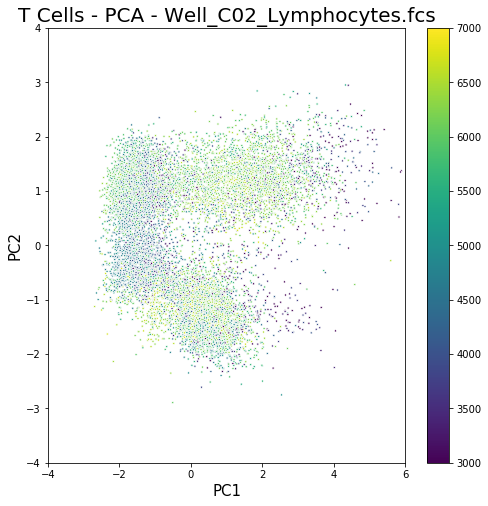

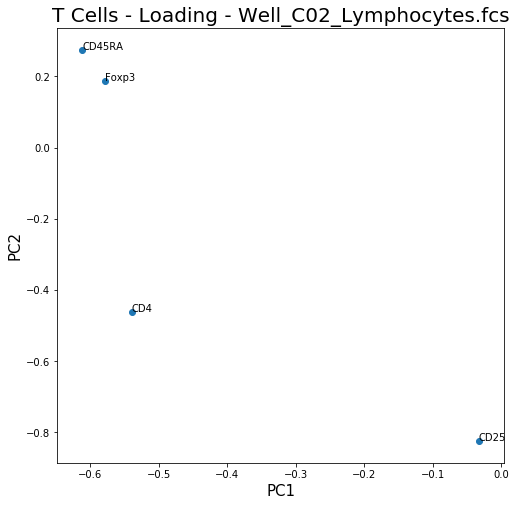

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


mean pStat activity:  4570.8745


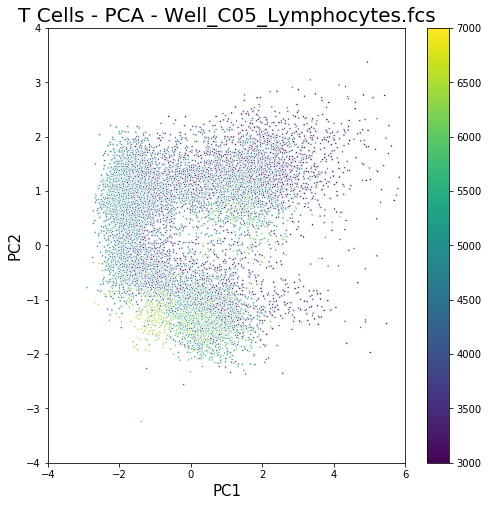

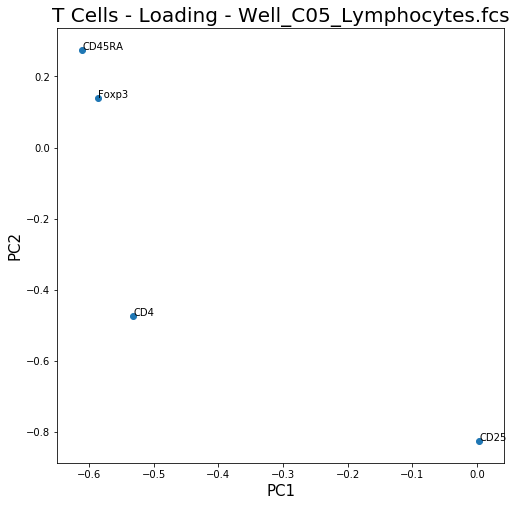

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


mean pStat activity:  4033.4734


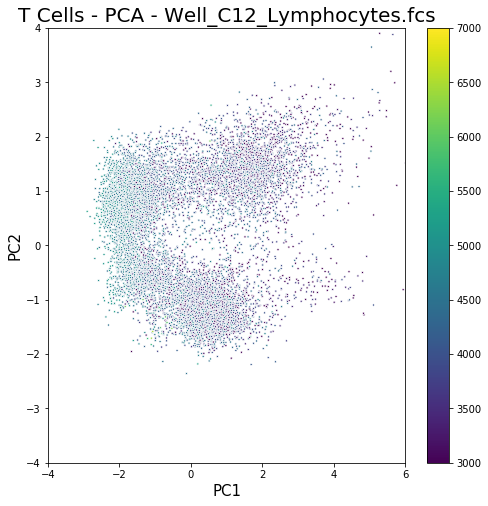

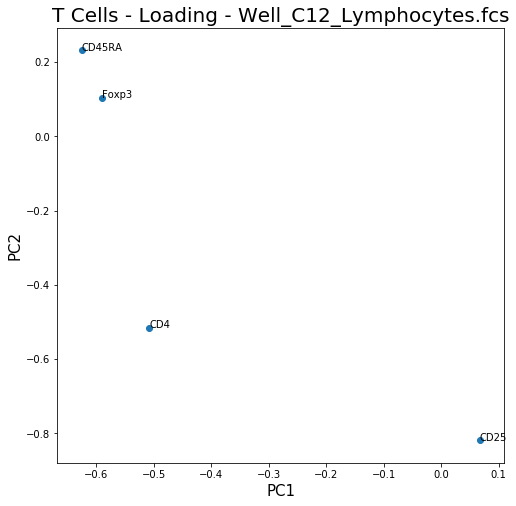

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


mean pStat activity:  4810.235


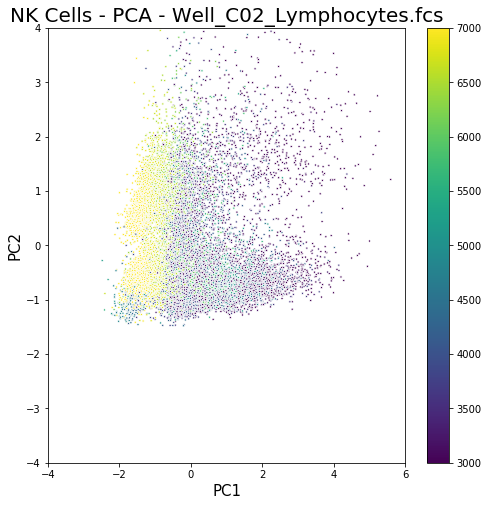

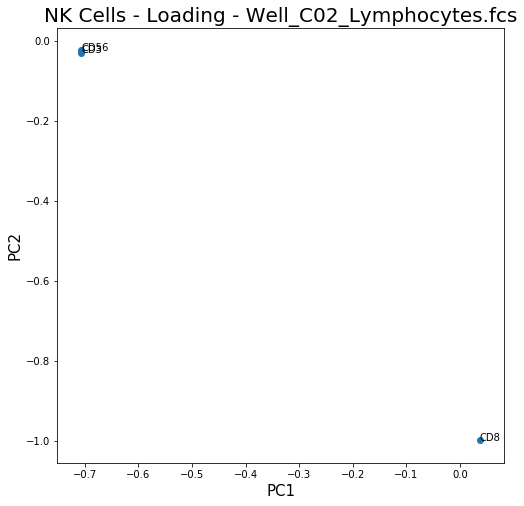

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


mean pStat activity:  4805.257


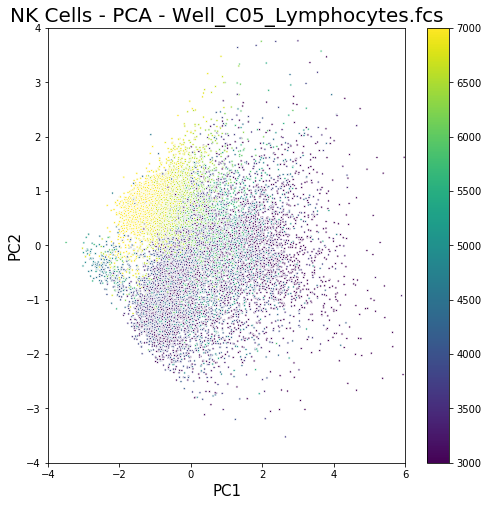

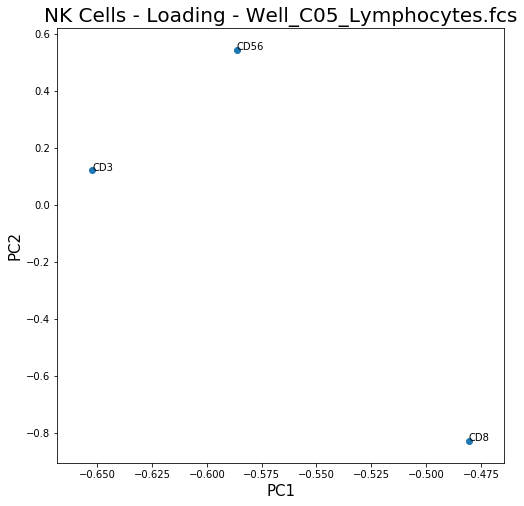

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


mean pStat activity:  4814.1704


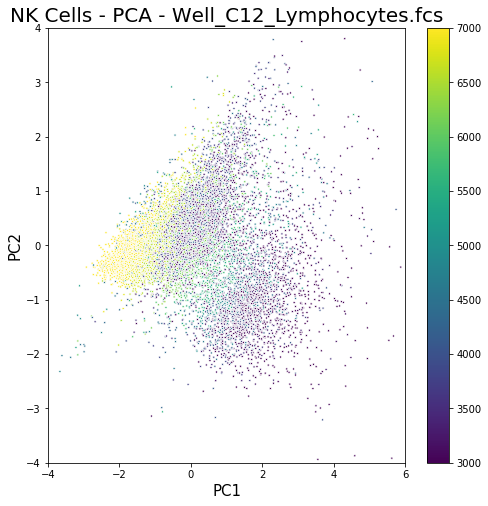

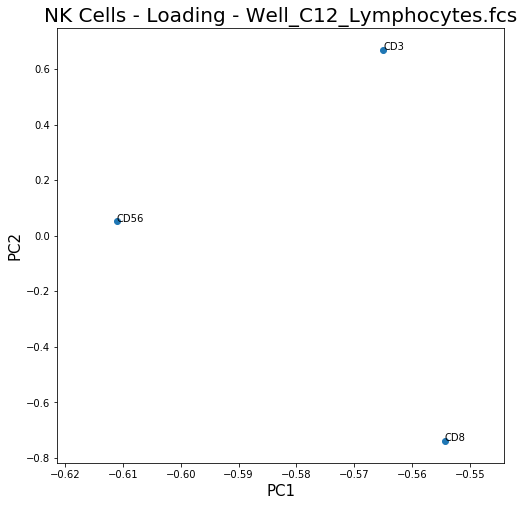

In [2]:
tplate = "/home/heatherm/type-I-ckine-model/ckine/brian/ti"
nkplate = "/home/heatherm/type-I-ckine-model/ckine/brian/ti"
tsample, titlesT = importF(tplate)
nksample, titlesNK = importF(nkplate)

dataT_array, pstatT_array, xfT_array, loadingT_array = pcaAll(tsample, "t", titlesT)
dataNK_array, pstatNK_array, xfNK_array, loadingNK_array = pcaAll(nksample, "n", titlesNK)